In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import norse
from norse.torch import li_step, LICell, LIState, LIParameters, LIF
from norse.torch import lif_step, LIFCell, LIFState, LIFParameters
from norse.torch.module import leaky_integrator as li
from norse.torch.functional import lif as lif
import ProjectMethods as pm
from scipy.signal import convolve2d
from torch.nn import Conv2d as conv2


N=100
U = 2
T=200

data = pm.create_sparse_data(100, 100, 100)
matrix = pm.sparse_data_to_sparse_matrix(data, [100, 100, 100])

matrix2 = torch.zeros(100,100)
kernel = torch.ones([10,10])
for nr, array in enumerate(matrix, start=0):
    convolved = convolve2d(array, kernel, mode="valid")
    matrix2[nr] = torch.from_numpy(convolved[::10, ::10]).flatten()

Activity in position  [77 , 89] 


In [2]:
p2 = LIFParameters(tau_syn_inv = torch.as_tensor(1.0 / 5e-3), 
tau_mem_inv = torch.as_tensor(0.7 / 1e-2), v_leak = torch.as_tensor(0), 
v_th = torch.as_tensor(1))

cell3 = LIFCell(p=p2)
print(cell3)
state3 = None

LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(70.), v_leak=tensor(0), v_th=tensor(1), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)


Spikes: tensor([ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
         0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0., 58., 43.,  1.,  0.,  0.,  1.,
         0.,  2.,  0.,  1., 20., 10.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  2.,
         0.,  0.], grad_fn=<AddBackward0>)
Spike maximum indices: tensor([78, 79, 88, 89])
tensor([75., 85.])


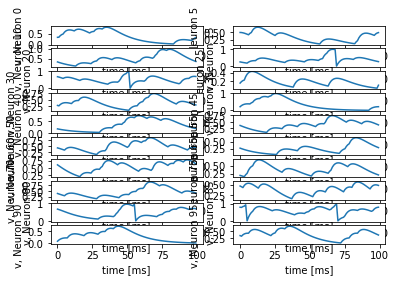

In [6]:
voltages = torch.zeros(N,100)
spikes = torch.zeros(N)
for t, array in enumerate(matrix2,start=0):

    output, state3 = cell3(input_tensor=array, state=state3)
    spikes = spikes + output
    
    for i in range(100):
        voltages[i][t] = state3.v[i]


print("Spikes: {}".format(spikes))
tp_val, tp_ind = torch.topk(spikes, 4)
print("Spike maximum indices: {}".format(tp_ind))
avg = torch.tensor([0,0])
for nr in tp_ind:
    avg = avg + pm.neuron_nr_to_coord(nr)
print("Spike_max approximate position : {}".format(avg/tp_ind.size(0)))
pm.plotNeurons(voltages.detach(),N)